In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from default_constants import *
from ECE_mechanism.voltammogram_ECE_no_plot import CSV_ECE_ox
from plot_tools import extract_expe_like_CSV
from scipy.optimize import minimize

def plot_experimental_data(folder_name):
    directory = folder_name
    for filename in os.listdir(directory):
        if filename.endswith(".txt"): 
            path = os.path.join(directory, filename)
            df = pd.read_csv(path, delimiter = ';', decimal = ',')
            Potential = df['Potential applied (V)'].to_numpy()
            Intensity = df['WE(1).Current (A)'].to_numpy()
            plt.plot(Potential, Intensity, label = path)
            continue
        else:
            continue
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        
    
def find_expe_csts_CSV(file_name):
    df = pd.read_csv(file_name, delimiter = ';', decimal = ',')
    Potential = df['Potential applied (V)'].to_numpy()
    Time      = df['Time (s)'].to_numpy()
    E_ox = max(Potential)
    E_red = min(Potential)
    E_start = Potential[0]
    Delta_E = Potential[1] - Potential[0]
    v = Delta_E/(Time[1] - Time[0])
    return(E_ox, E_red, Delta_E, v, E_start)

def find_I_E_t(file_name):
    df = pd.read_csv(file_name, delimiter = ';', decimal = ',')
    Pot_ap = df['Potential applied (V)'].to_numpy()
    I_expe = df['WE(1).Current (A)'].to_numpy()
    Time   = df['Time (s)'].to_numpy()
    return(I_expe, Pot_ap, Time)

def set_expe_cst(cst_all, cst_expe_new):
    cst_all_new = list(cst_all)
    cst_expe_new = list(cst_expe_new)
    cst_all_new[4] = list(cst_all_new[4])
    for i in range(len(cst_all_new[4])):
        cst_all_new[4][i] = cst_expe_new[i]
    cst_all_new[4] = tuple(cst_all_new[4])
    cst_all_new = tuple(cst_all_new)
    return(cst_all_new)   

def guess_potentials(E_0_1, E_0_2, cst_all):
    cst_all_new = list(cst_all)
    cst_all_new[2] = list(cst_all_new[2])
    cst_all_new[2][0] = E_0_1
    cst_all_new[2][9] = E_0_2
    cst_all_new[2] = tuple(cst_all_new[2])
    cst_all_new = tuple(cst_all_new)
    return(cst_all_new)  
    
def I_new(new_guess, *cst_expe_set):
    cst_expe_guess = cst_expe_set
    cst_expe_guess = list(cst_expe_guess)
    cst_expe_guess[2] = list(cst_expe_guess[2])
    cst_expe_guess[2][0] = new_guess[0]
    cst_expe_guess[2][9] = new_guess[1]
    cst_expe_guess[2][6] = new_guess[2]
    cst_expe_guess[2][7] = new_guess[3]
    cst_expe_guess[2][4] = new_guess[4]
    cst_expe_guess[2] = tuple(cst_expe_guess[2])
    cst_expe_guess = tuple(cst_expe_guess)
    I_simu_CSV = CSV_ECE_ox(cst_expe_guess)
    E_expe, I_simu_CSV_2 = extract_expe_like_CSV(cst_expe_guess, I_simu_CSV)
    return(I_simu_CSV_2)

def Error_I(I_new, *I_expe_CSV):
    Error = 0
    I_new = I_new/max(I_new)
    I_expe_CSV = I_expe_CSV/max(I_expe_CSV)
    for i in range(len(I_new)):
        Delta_I = I_new[i] - I_expe_CSV[i]
        Error += Delta_I**2
    print(Error)
    return(Error)

def fun_1(new_guess, *fixed_parms):
    cst_expe_set = fixed_parms[0]
    I_expe = fixed_parms[1]
    I = I_new(new_guess, *cst_expe_set)
    Err = Error_I(I, *I_expe)
    return(Err)
    

    # fitting with the error
def fit_experimental_data(file_name, guess):
    path = os.path.join('Examples_ECE', file_name)
    # adjust set up parameters
    cst_expe = find_experimental_potentials_CSV(path)
    cst_default = set_default_constants()
    cst_expe_set = set_expe_cst(cst_default, cst_expe)
    
    # define the function to minimize :
    cst_syst_guess = guess_potentials(guess[0], guess[1] , cst_expe_set)
    
    df = pd.read_csv(path, delimiter = ';', decimal = ',')
    I_expe_CSV = df['WE(1).Current (A)'].to_numpy()
    I_expe_CSV = I_expe_CSV/max(I_expe_CSV)
    E_expe_CSV = df['Potential applied (V)'].to_numpy()

    Best = minimize(fun_1, guess, 
                    args = (cst_expe_set, I_expe_CSV),  
                    method='SLSQP', 
                    bounds= ((0.4,0.8),(0.3,0.8), (0.001,10), (0.001,20), (0.00001,1))
                   )   
    #print(cst_expe_set[2])  
    return(Best)

    # curve fitting with the error
def fit_experimental_data_2(file_name, guess):
    path = os.path.join('Examples_ECE', file_name)
    # adjust set up parameters
    cst_expe = find_experimental_potentials_CSV(path)
    cst_default = set_default_constants()
    cst_expe_set = set_expe_cst(cst_default, cst_expe)
    
    # define the function to minimize :
    cst_syst_guess = guess_potentials(guess[0], guess[1] , cst_expe_set)
    
    df = pd.read_csv(path, delimiter = ';', decimal = ',')
    I_expe_CSV = df['WE(1).Current (A)'].to_numpy()
    I_expe_CSV = I_expe_CSV/max(I_expe_CSV)
    E_expe_CSV = df['Potential applied (V)'].to_numpy()

    Best = minimize(fun_1, (0.6, 0.5, 1, 1, 0.01), args = (cst_expe_set, I_expe_CSV), method='SLSQP')   
    #print(cst_expe_set[2])  
    return(Best)

In [2]:
path = os.path.join('Fit_Experimental_CSV', 'Examples_ECE')
print(path)

Fit_Experimental_CSV/Examples_ECE


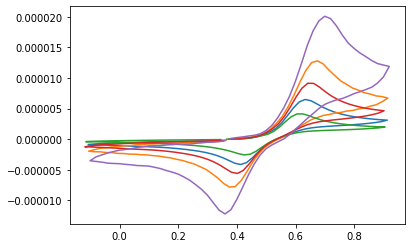

In [3]:
plot_experimental_data(path)

In [4]:
path_file = os.path.join(path, 'Che207 Ni(BinapSQ) 500mV s.txt')


In [5]:
def fit_expe(guess, path_file, cst_all):
    # set new values for cst_all extracted from the experimental data
    (E_ox, E_red, Delta_E, v, E_i) = find_expe_csts_CSV(path_file)
    cst_all["E_ox"]    = E_ox
    cst_all["E_red"]   = E_red
    cst_all["Delta_E"] = Delta_E
    if Delta_E > 0 :
        cst_all["Ox"]  = True
    else:
        cst_all["Ox"]  = False
    cst_all["v"]       = v
    cst_all["E_i"]     = E_i
    
    # extract I_expe from the datas
    (I_expe, Pot_ap, Time) = find_I_E_t(path_file)
    print(len(I_expe))
    
    # minimize the distance between I_expe and I_simulates
    Best = minimize(fun_ECE, guess, 
                    args = (cst_all, I_expe),  
                    method='L-BFGS-B', 
                    bounds= ((0.01,10000), (0.4,0.8), (0.3,0.8), (0.001,20), (0.00001,1)),
                    tol = 0.1)  
    return(Best)

# guess = (Lambda, E_0_1, E_0_2, k_p, k_m)
def fun_ECE(guess, *fixed_parms):
    # set the new constants for cst_all
    cst_new = fixed_parms[0]
    cst_new["Lambda"] = guess[0]
    cst_new["E_0_1"]  = guess[1]
    cst_new["E_0_2"]  = guess[2]
    cst_new["k_p"]    = guess[3]
    cst_new["k_m"]    = guess[4]
    
    # calculate the I correspomnding to theses new constants
    (param, E, C_init, M_new_constant, M_old, fun, fun_I) = initialise(cst_new)
    (I, Potential, Time) = calculate_I(param, E, C_init, M_new_constant, M_old, fun, fun_I)
    (Pot_expe, I) = extract_expe_like_CSV(param, I)
    
    # calculate the error between experimental and simulated intensity
    Err = Error_I(I, *fixed_parms[1])
    return(Err)


def Error_I(I_new, *I_expe_CSV):
    Error = 0
    I_new = I_new/max(I_new)
    I_expe_CSV = I_expe_CSV/max(I_expe_CSV)
    for i in range(len(I_new)):
        Delta_I = I_new[i] - I_expe_CSV[i]
        Error += Delta_I**2
    print(Error)
    return(Error)

In [6]:
from default_constants import default_constants
from main import *

#main programm to fit the data :
cst_all = default_constants()
# set mechanism type :
cst_all["mechanism"] = 'ECE'
# set molecule type :
cst_all["Reducible"] = False
# set concentration :
cst_all["C_a"] = 2E-3

path = os.path.join('Fit_Experimental_CSV', 'Examples_ECE')
path_file = os.path.join(path, 'Che207 Ni(BinapSQ) 500mV s.txt')
#guess = (100, 0.5, 0.5, 1.0, 1.0)
guess = (100, 5.55824144e-01, 4.41382398e-01, 9.71843960e-01, 1.00000000e+01)

Best = fit_expe(guess, path_file, cst_all)


102
358.5091789577226
358.50917895769487
358.50917774184467
358.5091773656504
358.5091809781585
358.5091785419629
153.68929788468515
153.68929788467247
153.68929983418195
153.6892978867959
153.68929878627947
153.68929788444606
191.48983601286008
191.4898360128539
191.48981789550672
191.48983601301262
191.48983832987196
191.48983601261023
162.60547901444951
162.6054790144408
162.60547169557205
162.60547902607934
162.6054809860109
162.60547901416444
159.42762601814061
159.4276260181246
159.42763436431636
159.42762603736418
159.42762741088927
159.42762601788306
153.54549623069224
153.54549623068115
153.54549562591802
153.54549623274636
153.5454971239461
153.54549623045176


In [7]:
Best

      fun: 153.54549623069224
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.10844667e-03, -6.04774215e+01,  2.05412221e-01,  8.93253855e+01,
       -2.40476083e-02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 2
   status: 0
  success: True
        x: array([1.00002773e+02, 7.97815033e-01, 8.00000000e-01, 1.00000000e-03,
       1.00000000e+00])

In [13]:
#main programm to fit the data :
cst_all = default_constants()
# set mechanism type :
cst_all["mechanism"] = 'ECE'
# set molecule type :
cst_all["Reducible"] = False
# set concentration :
cst_all["C_a"] = 2E-3

# set new values for cst_all extracted from the experimental data
(E_ox, E_red, Delta_E, v, E_i) = find_expe_csts_CSV(path_file)
cst_all["E_ox"]    = E_ox
cst_all["E_red"]   = E_red
cst_all["Delta_E"] = Delta_E
if Delta_E > 0 :
    cst_all["Ox"]  = True
else:
    cst_all["Ox"]  = False
cst_all["v"]       = v
cst_all["E_i"]     = E_i


 # extract I_expe from the datas
(I_expe, Pot_ap, Time) = find_I_E_t(path_file)

guess = np.array([2, 0.5, 0.5, 1.0, 1.0])

def fun_ECE_cma(guess):
    # set the new constants for cst_all
    (param, E, C_init, M_new_constant, M_old, fun, fun_I) = initialise(cst_all)
    cst_new = param
    cst_new["Lambda"] = 10**(guess[0])
    cst_new["E_0_1"]  = guess[1]
    cst_new["E_0_2"]  = guess[2]
    cst_new["k_p"]    = 10**(guess[3])
    cst_new["k_m"]    = 10**(guess[4])
    
    # calculate the I correspomnding to theses new constants
    (param, E, C_init, M_new_constant, M_old, fun, fun_I) = initialise(cst_new)
    (I_simu, Potential, Time) = calculate_I(param, E, C_init, M_new_constant, M_old, fun, fun_I)
    (Pot_expe, I_new) = extract_expe_like_CSV(param, I_simu)

    # calculate the error between experimental and simulated intensity
    Err = Error_I(I_new, I_expe)
    return(Err)

def Error_I(I_new, I_expe_CSV):
    #print(len(I_new), len(I_expe_CSV))
    Error = 0
    I_new = I_new/max(I_new)
    I_expe_CSV = I_expe_CSV/max(I_expe_CSV)
    for i in range(len(I_new)):
        Delta_I = I_new[i] - I_expe_CSV[i]
        Error += Delta_I**2
    print(Error)
    return(Error)

import cma
from cma.evolution_strategy import CMAEvolutionStrategy
opts = cma.CMAOptions()
opts.set({'popsize': 200, 
          'maxiter' : 100000, 
          'maxfevals' : 10000, 
          'timeout' : "100000000.0 * 60**2", 
          'tolfun': 1e-4, 
          'tolfunhist': 1e-6})
es = CMAEvolutionStrategy(guess.astype(np.float16), 1, opts)
es.optimize(fun_ECE_cma, verb_disp=100, n_jobs = -1)

(100_w,200)-aCMA-ES (mu_w=52.6,w_1=4%) in dimension 5 (seed=876039, Fri Feb 19 16:41:44 2021)
4796.361859818732
24360935170.371628
352.7454063497824
961.0764970660622
326.29933128824285
1479.3072158297775
2456.143403591222
1250.921707635416
405.8300885849281
1495.9705300630742
2450.951769150903
194.58377705908427
161.74427613454512
3022.6096766045816
465.66153421544493
68.97669538316063
872.8791728297593
198.57084169937792
45.292697025753746
887.0298544496445
268.9348263911179
759.2319117631578
706.7018150467719
213.69069085983602
700.295581060567
851.067754105907
2221.3080232733487
810.1593439682553
915.6780622662471
8321.224891188376
51.90217108939182
15954.440443725272
120.76876536800366
669397.744434104
2340.789170777824
2457.344543902382
1104.894605779501
59.10075806344325
120.30092657433794
1958440.1513886682
97826.3776667019
16129.24017363191
774.7611712204694
1200.574591746936
12147.206320050975
52.05781369242957
2917.1954177488115
1565.3472590094282
10611.29284254178
3605.7943

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


nan
3794.721972886107


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


nan
1.9708149752420205e+22
599.0281955043308
902.1156489809642
2456.1433717420778
77.17409388738929
2483.3217580580986
4531.292956310033
878.5929803072173
52.12010714319737
76370.23087424062
343052506363491.9
1839.3209765296547
2496.6393771112816
171.16448884027616
2456.143238507612
1045.3182750583724
924.3999632912335
157.38362165828187
155.84975876441234
473.40681051681344
1.420861122018064e+16
39.649457508935626
71.85252731850495
806.0226247613181
5130.302858715931
124.0714077732891
672430.193339937
3585.3860880571683
108.03092729069893
702216922253758.6
8070.219841672941
74.54332695771622
25718.225903704904
1083.7164203308294
177.51280665590718
923.5447525547062
184918.42789001213
3462.158109924558
260679.79720258524
1.1355263493169058e+19
142.55270204820735
97.55241940394265
2455.5215534975428
2456.1433910932597
5174.027488136085
468.5539894461681
32.17588000798499
394.050079798745
2456.143391699209
5.109042586970188e+22
59.94462220148858
39.595173038714414
22601.718302803998
401.

/usr/local/anaconda3/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [97, 103]/[] are nan/None and will be set to the median value 916.5964748416593 (class=CMAEvolutionStrategy method=ask )
  ')')


50.77470726165935
7.367660939329661e+22
185.93152510591315
68.2645452974536
46.53138636775003
158.5202277227662
154.34833779240975
160.17414005094747
65.8311653932569
120.68567616942322


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


nan
2456.143391696384
2456.1435066994263
430.00285414829955
58.04084967662592
1559.6626378765714
51.61300537274176
1066.6938068515753
36.9042168868599
17852.21734420684
248.54378451996584
17.001956885985148
1043.6352039329613
68.06570257506465
509.4866309439354
7.902352729863407e+21
788.3506668468581
107.50786422603304
51.85444361360313
51.52261745667661
51.590554590485084
4037.51908569118
13173234.644374214
2456.129850294524
19.535631956210462
62.44364222417671
160.26237171900135
364.7523676847795
nan
86713.16751636539
52.34644532631659
4409.328914426115
15351.234486431602
935.739192201771
36.246928789446066
2181.147213454051
18.333542243736126
51.83971819661593
388.01753419558287
117.69973742789125
17.95694953439381
6440.882223528594
52.653789937610625
57.97093017569947
190.29823069972358
855.0193064396151


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


nan
1.6422974289759652e+23
86.91912117155105
663.4330154007888
27.683070331643528
2456.143391696384
6.136722900415738e+17
7.387220508319815e+22
1580.6136932331763
177.13638378948843
5544.25416336073
190.56563412662217
51.636311905313285
37.16005350793598
1235.52979626565
59.94390142189606
31.642564098237724
40.637615878805924
57.95438954382847
187.46043689536538
2.90673244982455e+22
125.99002986037638
52.41339837756607
100.68750393978247
32.994535866525446
53.85402831073896
102.32911670648909


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


nan
16.569795960851888
177.7517329955762
55.466142650013175
1.799500244552998e+18
9413.874859981926
53.52029145680364
77.88803151252424
4412.483971372537
51.59596370653526
38.38639866966312
2456.1433916972514
45.387029857223276
514.5766578365754
56.48533605575276
288012.9641188772
33.50633554970791
53.08936407946077
2456.1432514320895
nan
122.55647441560176
986.7754537079717
29.886823640032475
271.16315450648665
2.21455507901615e+23
9131.898282995811
2456.143391483669
63.34955194654204
52.12090664738056
52.587031697864724
944.9420752814556
51.63397765834408
1327.865735202309
1323.2431345131577
438.16847452509023
30.799069832729586
1.7674194660817334e+23
42.69067420219078
15021.723338830132
488.06822577154315
189.8930385800164


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


nan
791.8913272919672
3693105388615630.5
41.156080569409255
52.53561213126391
2456.212683748233
52.35823308343982
nan
271032.3429882156
2454.8754132794215
552.5543734229842
599.6253031346369
1657.8906135241136
465.530386108765
18.958387163650894
115.74227546512158
2473.10874770643
1073.90349440427
60.523834809681304
193.28211934100804


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


nan
51.92435284577703
9.045353282132232e+18
50.43079771446057
141.66578625554655
479.3371843517288
592.704001502718
4262163.363607628
123.50291999588589
436.0337847754191
51.60384056892842
1.1753997648990413e+22
76.32546349144852
16.32183337163745
2450.1524017489396
1.6258916103631618e+20
1049.834077148015
746.4810106183877
48.23923018821258
9.972467970111887e+18
1041.48601705798
53.58679787434362
53.386590271562966
305903261.8913402
29.26850422664202
524173.3943958696
805.7172606427524
8072170.8833414
2456.143391366261
148.3356731706301
2456.143386521105
3.1181629260676365e+21
28.527084146630038
252.65826080767295
54.79257020775509
67.88923258941952
4.9812177034941995e+20
44.62389858988702
51.59985732683249
17.722386486849274
2456.1433916963847
42.6107803589343
51.80955345475636
2456.143391696236
1609192.9552591795
54.90369715383832
159.84297639276133
51.981708828452405
52.40607022637729
3317.452811232164
1191.0388464095008
57.93433647583455
77.35377162306456
29.48850821357965
53.2579

/usr/local/anaconda3/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [8, 39, 56, 84, 102, 124, 131, 144]/[] are nan/None and will be set to the median value 181.84162905074467 (class=CMAEvolutionStrategy method=ask iteration=1)
  ')')


58.90961096469182
1605.1914242031282
1939616257058720.0
51.63209234728807
997.4576657749764
86.79541190928514
76.45156520403056
45.12334247047028
18.240139776614328
638545.666618439
nan
967.3585687168483
61.28905129729945
51.590811090370295
33383.093499285875
56.79073489295707
nan
51.598421446230944
27.45709644248017
270.167710201889
52.866358556222124
2101.06950143199
51.9555623558783
54.16198595586205
16.328462089904075
21.256314930547102
1164.3423183777625
33.429058891709516
187.56567131615907
nan
992.5478656038673
659.8591645408515
2.0567815195221673e+23
167.39922830050872
18.135099267174002
nan
23833551.9268305
51.54447260298456
16.86996460020181
51.5915130844584
22487697.47749734
49.91657539080766
52.74415267537974
726.5023058096742
nan
454138.06291709736
51.59094435079632
926.0079146799551
51.59654662809888
17.59322662030511
1.6431130617218554e+23
181.60688890097177


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide


nan
nan


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


nan
32.38896677056547
nan
43.48014957345685
95.33475043167925
2455.9796938911827
51.59091998077882
199.28972106138545
21.547040641017492
21618288885.580925
51.83514502213597
2487.796439578962
56.90898743935935
52.74766968724791
28.36056688126078
57.62803566534805
52.16944540574647
17.488769504158338
29.876721371250056
51.59569588524493
51.59025020763234
nan
52.00453675988414
806.365153125002
258.66182615124796
nan
13427.9149570472
34.54962299135489
51.62805828495795
34.184240037520176
119.93368648167215
nan
305.20092273498335
nan
21.865547821636277
52.1233703553176
1474.0774797895247
51.60715186229559
51.62795541245454
51.590529674755416
nan
nan
53.298567088453964
16430.96041155078
973.62945038833
46444061432297.86
49.181983980906956
32.49293136209833
54.29776258847626
51.618961170632545
51.3318242749212
37247.39243355429
68.57974483446685
57.4574326117073
nan
51.77583203336164
51.84247487944572
3238.309053804346
2456.143410636315
51.600355464016225
29.976458553455505
6.755176910299091

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide


nan
51.83236945245137
51.61726402428866
51.59075356752622
227.1508126371767
2860.1640462677315
55.1915444404706
166.5091047368343
51.80388785032282
82.63551665054368
175.09534799436784
nan
54.4630238973504
73.55079776090162
50.74762474858306
53.12872565634242
51.872891025990434
45.31614864940596
32.494930362154875
21.187358802894085
3095.378580525947
34.09318631012876
11217.292298287772
2456.146151584512
33.26425677867084
17.79744126387351
211.046666270505
14985.56986492817
nan
394.90913972890655
nan
51.565894368237124
51.590654835396414
1.566873388339389e+23
43.01908484632251
51.74634606158172
33.53158153613102
2455.4169120657216
1166129.2129176336
2456.1433916920705
54.621801803034785
61.749956831205154
51.46522351792957
2456.1433916951723
    3    600 1.632846208990408e+01 2.3e+00 2.00e+00  8e-01  2e+00 241:19.2


/usr/local/anaconda3/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [9, 16, 28, 34, 43, 51, 53, 54, 57, 77, 79, 86, 87, 94, 95, 108, 126, 135, 138, 150, 153, 157, 167, 184, 187]/[] are nan/None and will be set to the median value 54.621801803034785 (class=CMAEvolutionStrategy method=ask iteration=2)
  ')')


51.59102085347097
51.79197317377383
34.59911493228461
18.25505845825268
51.665872756268534
3754.886847573535
51.590526803482845
51.604039280872904
20.022220587045513
271.8895971497339
51.59039904998785
24.12610667687804
20.564802736302553
52.70677217879205
51.59053364980223
2455.9686854301067
15.537874675825673
11581666664.20337
51.06348191922762
51.590552494761404
51.588099700213455
82.50626785500631
51.829377430447586
52.47003253220728
18.968198057377624
51.59695703983089
51.59073805669375
921.3648288885415
20.219173695397025
nan
50.83179716221333
16.28455383890591
nan
91.01533591668773
51.05301046136313
29.249606504230872
51.82427117999787
16.395654850895998
43.390914148072234
51.553906120263214
51.594546155115054
51.64933368918065
51.594543889159034
51.590767317155034
51.745314717701014
15584.931873307001
207.0960876811646
1299.0788109527907
1711.6370287705238
51.63775404395153
51.63930642488874
16.453880564059414
51.64095796294888
51.60997439585253
52.261873782270094
344.766596275

/usr/local/anaconda3/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [30, 34, 75, 95]/[] are nan/None and will be set to the median value 51.59575159747297 (class=CMAEvolutionStrategy method=ask iteration=3)
  ')')


51.84318662724064
17.85103197334678
45.96872794076329
51.590479557186164
51.66513674828147
80.86754584024548
51.58623807989163
52.53369271988812
1865346.9682148786
15.552787705196934
64.7304524939641
51.59928475564012
51.60174538537095
18.694420763367624
21.252072659908368
55.60522156460397
23.04000202115549
51.51924827539533
51.59182790345216
51.59518642725236
17.88191982943926
12975781.43660933
61.42523614748697
177.47971080922153
34.029127565094754
51.601555961573744
21.480280907017114
51.65827462377843
53.70714711815731
51.6101497816622
51.626294029915414
599283351.4671375
23.618959366855314
51.63850366888642
26.02912680246377
165.23287770326547
53.84421533318228
56.231900185356565
51.592667520131634
51.71133348232588
30.297741589952523
51.38988984858917
99.17752527076942
234.14175658956586
27.464738336491454
51.68841180531089
51.605593860171176
63.861177044395255
76.95591033081345
65.4574566149757
18.241489877586854
51.4949167265318
51.999331732863546
51.591378125155444
54.5947648

/usr/local/anaconda3/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [70, 138]/[] are nan/None and will be set to the median value 51.59071389207392 (class=CMAEvolutionStrategy method=ask iteration=4)
  ')')


51.58309600673323
66.40105268659414
52.179081935271036
57.646011567199196
51.213589624974034
18.30318041036147
53.53492457774338
50.60543330824202
21.593649051539323
7.675461844466121e+17
51.593517478409055
46.48557660031829
51.592633738114166
18.3450224518036
51.59226017293513
52.0076192587181
52.04016662123833
46.43830843662966
51.59078081813643
18.847067106377207
51.67793817033501
41.60844795865494
51.472212148796984
50.67927728212122
55.98085919394578
51.60883009138241
22.90789961544214
51.78195462028839
50.107682225703115
787778669926.4316
51.59063783212034
53.77195876092337
17.347018033654958
51.59567745421334
11662111.198700795
15.703462265631032
6.551497613316619e+22
15.678635443726504
65.59582026252231
18.302925138719967
21.043361922818626
51.61277573971036
51.66482742569431
238.64600774485555
45.428484375532236
22.270554536102114
51.59760133746942
128979.62135852811
51.590535668962346
51.632331482384224
17.526716632151523
51.590649491457185
51.59055161829042
55.71653660857313

18.01310288938518
51.592812638645
51.723057253056304
16.902986867991096
52.30399052178127
15.847771194395849
50.99679778359514
20.433491061321142
17.06555106342962
18.013523390656545
25.13518682644277
54.88256270234867
15.57354374353024
110.95871709343993
55.155595077140426
17.292133742702823
31.87146075221183
878123507.0179366
23.097555371752467
21.576717442136466
51.59067611585752
51.59111282971455
36.991782254996544
52.21269675540625
51.59633780481743
17.62214112946925
54.05215535774367
36.759990677636814
8654289982.089699
17.5960308595063
17.215127733349323
16.416538834007756
16.433953391200387
18.342126795274293
15.616444757385072
51.7634475186978
9894847364252170.0
15.71407935644448
23.83267058825858
176.78749915663252
24.38577968798758
51.62302207161063
19.090480508435864
23.185797827937876
17.707507045319776
51.81499746561077
15.685494619520519
19.102741544842566
51.590642258795434
17.55849548186721
19.901544189635175
51.60050989865168
22.57681861450244
16.393748157667776
1.710

15.714092925976066
18.791421241134227
51.59075997216765
15.67872133593551
51.595118572669996
17.631026133674066
18.921997343617882
17.17618101470313
51.59059391991163
18.26182587605193
51.69037687511469
19.353791872460373
51.591024232747415
51.64817355696294
6.712271320665343e+16
51.87589729960521
17.625757969492383
51.59117476054782
25.084488812784013
7586540816.26655
51.593940105190434
42.12101471656478
16.34607787445939
15.68549461947381
17.273666503002918
15.72538161260174
51.59278702649839
1.860242705077301e+17
51.59227826222979
307.0368530785644
16.430085400373713
1.619498746003731e+17
262.52536567973465
2.6913521275517294e+25
15.678721336359603
17.0260398466518
8.18693400456752e+25
18.730793064222688
56.747255533719795
20.273735447366533
15.604591515099072
51.59982222380834
15.737328811336118
16.3939124769394
6295916323555.627
16.37524062137868
16.501204874681797
16.938551992876118
51.59055405984278
51.59053866841859
6470910805.463366
54.32411851697489
51.59053941404544
21.73226

18.20402707483338
16.91456323035562
17.921899116985728
16.37429967565315
17.260753318646362
51.605760816465235
15.685494619520506
51.5905360423134
18.081543534804744
4.115609973805399e+23
51.590788232753475
240.80391090579099
16.75930456656999
51.59053908764205
219.67160280870016
19.67239671898373
17.83789288332371
18.318514370955853
3.3707097979464914e+32
16.79857081614231
16.88605905876858
2.520612653168843e+18
17.413280192237888
18.407037416136493
51.866685405821265
17.57063101634056
56.78028288338454
19.24504302013582
51.61725201280454
51.5907529889423
819.4597851508763
18.2676059871426
15.59386715009336
15.678721336358926
19.174958401196026
18.278721336197336
16.918796592556753
17.100184838256055
16.275334694824263
18.113128016720506
18.41988498555546
16.59207975592693
51.596074246491
16.917291421000552
1.1829508931564924e+22
19.86562632220837
18.262540712938332
17.169972511398047
16.387187845752873
18.832173901903197
15.725381731467854
15.693772867154113
17.090762728168016
18.058

16.84777119519961
16.330555777171234
51.59062245599311
51.590698198705184
18.40789593840241
20.18380129871335
16.980508712079967
16.295748608852662
51.590585068815024
16.41719734764847
51.617236504417384
17.737893599136722
19.051722276816857
16.416632907372453
17.691233095531828
18.286717573418475
16.872042126575554
16.913340339181875
77.09291670454489
17.702239660574058
51.59076256738753
51.59053805639739
17.69725360114354
16.442315807944535
17.212399605006816
51.59060851032262
51.59515148399148
51.59182043918058
21.60477966183889
15.685494619520536
17.006378909264274
15.770725099195054
18.21672696896538
200.2891867043581
51.602518792250144
16.686604647155413
17.086811646800637
16.3161624074726
15.604591515097034
20.96564497498624
16.891985682548825
16.716143725823454
15.604591515099086
2.454786301918137e+22
18.937705344858877
16.871665833064647
16.413622559313676
15.630367620461266
51.639681740714984
17.665405705878396
8.193475288165723e+29
51.59208747110286
18.38558876883594
16.9922

15.593867150082755
51.59053797310944
16.41211738527854
15.604591515099083
15.563763669023471
51.71739376652733
18.06207034254749
17.241091985464895
6.394571361415337e+22
15.583613151971281
15.648523782267441
1.3442133184930653e+17
16.375146548037694
15.616444750851537
15.714092926199633
16.97138360590735
18.158495559364454
52.20643609344845
51.5905965687779
51.636230705517725
5.435358200759041e+22
51.59070901730488
15.648523782267313
16.873547300611794
51.590678979704784
17.814657366197114
16.47843911622797
15.725381731467195
16.957272603354806
18.201769313766423
15.749088221185565
15.648523782265265
15.678721336357123
16.47091324602851
16.91879659505854
15.71409292619666
17.65727260632123
16.892361975798572
15.685494619520378
51.7914612733648
51.72999501003033
51.60640639335341
15.703462634561117
51.60533521710629
7.394207144883435e+25
15.71409292619913
51.59092453197883
2.951266117043988e+27
1.0422674511172988e+16
15.68549461952051
15.616444757657405
51.59062614599771
16.460282954421

51.6009415324386
15.781355390706041
15.703462634561399
51.590576784627736
15.703462634572222
15.693773076705174
15.604591511942493
16.41729140478181
16.847771194875452
51.5906329125145
51.59155989466468
15.678721336359644
16.452004497715514
15.67872133635967
17.111270724873922
16.368843631749822
15.616444760322032
17.7939612232667
2.2031006472264105e+22
15.630367620450203
51.781263691234386
19.673265080478767
15.693773076717143
15.61644476061749
51.62894179819057
51.797392130439924
59.44188635635842
7.064448786701602e+19
51.59566670137424
17.17081917268355
15.678721336359564
1.1408048565067745e+21
15.63036762045925
   18   3600 1.555407411149816e+01 5.1e+01 2.91e+00  1e-01  1e+00 1805:06.9
51.59054968576739
16.41729142045564
15.685494619520524
2.698368274181712e+19
7.2879089283585226e+22
19.098758965692497
15.685494619520405
15.616444760621286
15.554074111522608
16.98361315197043
15.604591515099036
51.59863814213865
51.59146242187316
51.59056548379629
16.474393961318373
51.592556231859

51.59376801271456
19.56056517447646
7.301246390304003e+24
2.3298447895965897e+23
51.59053693451262
19.508072230053795
51.59435266707799
3.096256759003266e+21
18.22679283212547
17.664798476524428
16.313716632697957
1.4115450248458203e+19
   20   4000 1.555407411146039e+01 5.4e+01 2.78e+00  1e-01  1e+00 1865:53.9
16.463951861691573
51.59771757912425
17.08671757342491
16.91879659503385
17.242597159528884
16.88474203201621
51.590533032019835
51.590540415361055
51.590804693857734
16.4300854003299
51.59053426933686
18.95858963338403
15.648523782097557
1.713548910969168e+24
15.61644476060986
51.59088132033161
15.563763669342716
1.9410100743689607e+23
16.88982199459199
16.90271004752001
15.693773076717152
15.64852378225357
19.470348805785502
16.433942417458816
16.991891609123062
2.6130691909911046e+26
15.71409292618449
51.590518318207096
1.2676537697194693e+29
15.604591515099013
17.06555106354662
51.682404492147505
16.8935848930064
51.59169409781506
17.03413055546249
16.873547300611726
51.6019

16.375146548024816
15.593867150017587
52.11613890197376
56.80793902849503
51.590574332364724
51.5921091545919
51.59151149773862
17.03413055554606
15.630367620461262
3.224771355151509e+29
51.592702644986716
15.616444760630568
15.630367620381062
51.590557818286385
51.599433248021725
51.5909548466469
17.67016065903123
18.1480534153514
4.731268783787336e+22
1.3379403180071865e+24
51.63666660286966
51.590538255566564
15.714092926193379
15.58361315195538
51.59369486602912
15.70346263453142
15.604591515091256
5.778413659360525e+23
3.4922204734844865e+22
16.460471101178925
15.725381731467797
16.78286056466656
16.350217103057705
15.604591515097159
2.795698019832016e+22
7.427095073646756e+19
16.95727260634321
17.09941747926956
17.013810706058933
15.70346263457131
15.593867150094361
16.28549461951945
17.084083518812587
17.74043347185194
15.616444760625804
16.436952756894858
16.837046830242436
16.397065644924407
15.648523782267427
16.91879659506129
16.44033939844224
15.616444760630044
16.328015786

15.630367620461268
17.17354730061181
2.6764568843252973e+27
3.423312554653885e+26
15.678721336359647
18.06809104473175
51.591295736171936
16.415974393744424
51.8066434499578
16.891985682543307
17.261223688219708
15.693773076716797
17.696783424778666
51.59054083733942
52.06764659786654
51.67174924658559
15.714092926005893
5.87476798203126e+23
3.417955549094186e+23
18.522559530150815
51.59823146185445
51.590544126184554
4.2290864220951187e+21
15.749088222530887
51.59062221678635
18.389163481232085
2.0850024281786632e+27
51.59085496110572
18.040245324794476
15.678721334101919
7.888748010684298e+29
15.714092926188272
15.703462634568062
51.5905428598833
15.593867150082437
15.714092926167202
15.72538173146663
4.1384077050041755e+27
16.91456329308567
16.35040524981186
51.590622322027
15.616444760630536
51.593249580952794
15.693773076717004
16.873547300611783
51.59889052634683
4.455584005714391e+28
18.823970630809267
16.420395842526837
18.916162540450582
51.6509295599969
17.76592735713348
51.5

1.7069057975185367e+26
15.714092926162845
16.83704683023099
15.693773076716822
51.5933111360792
2.1108633014620065e+20
51.66506656114717
15.703462634572265
3.2953495807380425e+22
4.7219733203080844e+25
18.190480508513804
16.380602803944676
15.604591515097958
16.412117385279775
17.023500263922585
16.884742030968397
15.593867150092462
17.638834223904173
16.430085400347153
18.24570158092821
15.69377307671613
17.57683986881191
16.34306752639
16.42566395159973
51.59135127837415
51.59891904805304
51.59078022251794
16.81569217361119
15.630367620242094
15.616444760630161
4.1463835542530106e+24
18.869313998592617
52.850530982777705
20.344760847175863
5.918978564139986e+24
16.453697818053776
1.277116171325748e+22
15.648523782267308
51.60260465064976
1.1046394619304707e+25
18.05181635047068
8.876160568228256e+17
15.678721336359674
15.60459151403555
15.714092926172427
51.62289566061512
18.98013243701737
2.1076836868180232e+18
3.238929373428421e+23
16.423312117170525
17.169502145423355
1.5308689248

7.389153188744135e+24
3.6801006410065597e+18
16.815692173611076
17.77382952074378
15.604591515005467
15.703462634572062
15.616444760630603
1.462540941748456e+25
15.725381731369405
3.553989732694458e+22
16.43008540033611
51.59060554506799
16.918796595059117
51.590986671978456
1.7787361207967196e+23
51.60004629649886
15.749088222502865
17.1727947135935
16.306472982643573
51.590553293698704
18.844666773824017
15.72538173146773
15.616444760627704
51.59080349739581
15.604591515077068
15.604591515098122
17.002521899706263
17.141656425736308
6.123866877283157e+21
5.977494589852937e+25
15.630367620461143
4.294089597790963e+26
51.59104009392878
51.5913149959869
51.59069862593328
18.15774297323643
15.604591514993443
16.32801578601323
16.881731684419574
15.725381731466456
17.600170066369387
18.376369501928313
9.173615640057026e+23
15.703462634567641
15.604591515079493
6.0204198634721546e+26
15.604591515098964
16.390292365041958
15.737329050369032
17.176275428553197
17.057366678885526
16.958871853

2.672792607179214e+23
15.714092926189556
15.64852378226428
16.902710047553985
15.630367620460865
51.59066304649461
15.604591515067233
4.8595803126604864e+23
1.2728333795981186e+27
15.703462634571077
17.62651061197587
51.59276306525354
2.4935494119189115e+24
51.59124050884107
51.62702876336407
16.474393961007245
2.485931221295633e+25
17.614186999576525
17.579944290262837
17.738834224427546
17.64447862704637
15.72538173146282
16.762070348575644
51.60795318167328
6.742497971317168e+24
17.169502145395132
7.863087101900739e+21
51.59111657667193
15.70346263457227
15.693773076717122
4.261818926009572e+20
15.604591515071338
15.749088222527764
16.43554165620991
4.118139600101605e+25
15.593867149863947
1.4992341292440113e+26
16.36009480766542
51.59093495409411
15.725381731466598
15.61644476063038
15.703462634572123
16.39565454427646
15.737329050352212
15.678721336352156
15.630367620461271
2.3022915305838324e+24
19.04240901275088
19.54334974651499
51.590874149870096
16.285494619493974
51.59057348

15.703462634572258
51.59227507768788
18.138363857478687
18.060565173928126
15.604591515090908
15.760282954344218
18.432625381515237
51.59060019172045
51.59054325701774
17.099417479349125
18.125005437957736
51.597081635079654
51.59219248698984
5.97335912179942e+26
7.544215048962657e+21
16.94833563549121
51.607336793499044
16.436952756868884
18.072982860307103
15.630367620460438
15.678721336358905
17.519737328834424
1.0981198701748708e+21
18.43046162255895
15.630367620460838
1.6603188810754425e+23
17.034130555550473
17.648053407774846
51.591954368697735
16.914563293085443
16.37514654802483
51.59189177621308
16.500358212800354
5.2426401771242455e+19
16.44071569195746
16.387187938600746
3.5394575990909606e+25
17.78502425263587
17.559342220649402
51.59832456765747
17.084836105879592
51.59122949009974
51.5921955913346
2.1318721784477936e+24
51.59111697080398
51.59091714097641
51.59061463112934
1.7302088579844657e+19
15.593867150092107
16.90261597417702
16.52622839186209
19.56225849483443
16.

16.502992267685233
15.630367620427776
17.699605625729358
5.996096708110725e+22
15.593867150094157
16.893020489555003
2.458736987352758e+20
51.60786271682541
16.28549461946454
16.983613151956103
51.61621774926485
16.98050873052685
16.914563293085887
19.492644196171703
1.2056245686400349e+20
15.725381731463733
1.297918921880187e+25
15.703462634571277
15.678721336359404
51.59457634047644
19.27477025453386
15.593867150085304
3.028829204941482e+23
16.891985682549596
15.630367620461088
15.737329050376411
16.913904779441964
15.71409292619732
15.693773076693079
51.5908307178229
16.93657646318958
16.43008540034296
15.725381731457704
51.610040412055824
16.96235256870982
51.59053856689974
18.941750491592565
15.703462634572231
17.204873735228045
51.61030639020546
16.818890668258458
15.64852378226748
15.67872133635967
1.7634158953066706e+22
15.693773076716834
18.093396783147504
51.603779947426105
16.882296124690107
15.714092926199529
51.61072030896741
20.165927357020042
16.90271004748951
51.5914173

18.352098572044365
51.59080239767136
51.59088854959535
15.71409292619358
1.4625695816797862e+18
51.5954880238739
16.369972512576553
2.242531873043306e+23
15.604591515098726
20.760753321275878
18.223312117167932
4.621816505145647e+23
51.59912433572241
15.685494619520489
51.59180662957378
18.556708166282185
51.607705493645334
51.59093818177848
18.129897253575
17.023500263922756
15.70346263457215
5.43112812418778e+18
18.217291421014874
15.630367620461262
51.59092840218386
51.59164958533452
15.725381731348321
16.90261597417678
17.525193584759236
16.332249087999394
15.703462634571933
18.080885024030398
16.3742998876164
17.050217103161547
15.60459151509859
15.693773076088895
17.017479567610682
19.44673638809217
16.328015786030402
51.593665201512245
15.604591515068106
17.222841750288783
15.616444760627619
15.630367620457786
15.648523782266547
17.858025193343202
51.59546374146594
1.0081752056462905e+26
16.437423123510246
16.32161879629096
2.865104630032529e+27
18.222747676892197
   37   7400 1

17.01926696149442
15.616444760630579
17.5129640456733
51.59053104811418
16.957272606332754
51.59421977514452
16.350405249812017
16.360094807667096
15.630367620457656
15.60459151509592
17.73074391396476
51.65398906685123
51.591920223006916
18.809389257338115
15.604591515097875
15.770725099294086
4.565889113366452e+23
15.725381731323411
18.840715691925872
2.276682176217033e+26
18.962070348383506
5.8513915113940146e+26
16.482672418203176
15.616444760630513
17.023500263919768
15.703462634571984
17.659530367403764
15.703462634572196
16.904873735230616
   39   7800 1.556376366937733e+01 1.8e+02 2.50e+00  5e-02  9e-01 2443:33.4
1.5046614223287716e+23
51.59065623924239
3.539367577168722e+26
15.6485237822674
9.80199122889069e+23
1.1575586594756418e+22
51.59305358510572
15.725381731463044
51.60026946061894
51.59106738365288
16.914563293084743
17.629332813315145
17.12820393278514
16.514281072954102
18.156520019304686
17.190762728648664
51.592442735202866
17.64024532507029
1.9464794443481514e+20
4

51.62544872087804
16.440715692009462
16.494525663730318
5.907990676008478e+22
15.693773076713544
18.95962444071631
19.410329991107247
15.616444760628347
51.591004952927875
15.630367620354335
51.59082484635638
   41   8200 1.558361315197380e+01 2.1e+02 2.50e+00  6e-02  1e+00 2505:35.2
16.881731684430928
16.9145632930811
16.91334033893195
17.64118605884331
17.677592455831427
51.59067201431771
18.945419360815208
15.703462634504424
16.47091324600904
15.703462633912304
16.33121428098768
20.18032058345939
3.6174896251659275e+20
16.305438175484092
6.046793136046101e+21
17.214186999575546
51.59072482705275
3.214998352164511e+22
17.21239960540355
16.442314939373077
16.78286056494885
17.01381070603919
16.33977495818435
15.60459151509431
18.345137140714197
1.1886830364728523e+23
16.99424344347203
8.650529892118754e+22
51.60627784944303
15.604591515098386
16.440715691991418
15.648523782263865
9.622522572516476e+21
15.648523782266635
17.034130555450936
51.59361721469933
16.393490855035324
51.605990

16.891985682549244
17.198288598824888
16.324440997698346
1.585202185917221e+27
19.317855861282936
15.725381731409739
17.763011082340658
16.39349085657666
17.699417479270284
16.877968749213736
51.59135513439215
18.157084459475993
4.135127930178845e+25
15.604591515098932
16.415974393743202
16.83704683024453
16.32444099771355
15.604591515097079
3.3419400505849547e+22
15.616444760591785
7.712527549140363e+18
15.71409292602314
18.39875896486272
15.573547300603893
51.59170891991321
16.914563293076814
17.52726319901075
16.914563293085774
15.714092926193032
51.69095796198405
3.0301830909154377e+24
5.398221048151961e+24
51.592337373398614
15.725381731444605
15.604591515089718
3.422292099022306e+24
15.604591515095525
16.36009480766689
17.041938645860736
51.595579989942244
15.714092925996981
16.924629144449632
51.60488426593547
17.758025193365366
51.59250681117854
17.06197627521091
17.60835445030447
17.14551343496584
16.902615974174548
17.675052474789197
17.694431590111392
15.648523782221933
51.9

KeyboardInterrupt: 

In [16]:
path_file

'Fit_Experimental_CSV/Examples_ECE/Che207 Ni(BinapSQ) 500mV s.txt'

In [17]:
es.result

CMAEvolutionStrategyResult(xbest=array([ 3.6818689 , -1.29059841,  0.39065021, -2.04667513,  1.36033813]), fbest=15.531681077798563, evals_best=1113, evaluations=8600, iterations=43, xfavorite=array([ 5.290107  , -1.62730494, -0.82575665, -2.8797261 ,  1.39798057]), stds=array([0.54692266, 0.06309679, 1.05372021, 1.23533475, 0.92067766]), stop={})

In [18]:
96500/(8.314*300)

38.68976024376554

In [19]:
1/38.7

0.025839793281653745